# Makemore 3 (bis): vers une torchification, statistiques d'activation

## Reprise

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Words(object):

    def __init__(self, filename):
        self.filename = filename
        self.words = open(self.filename, 'r').read().splitlines()
        self.nb_words = len(self.words)
        self.chars = sorted(list(set(''.join(self.words))))
        self.nb_chars = len(self.chars) + 1  # On ajoute 1 pour EOS
        self.ctoi = {c:i+1 for i,c in enumerate(self.chars)}
        self.ctoi['.'] = 0
        self.itoc = {i:s for s,i in self.ctoi.items()}

    def __repr__(self):
        l = []
        l.append("<Words")
        l.append(f'  filename="{self.filename}"')
        l.append(f'  nb_words="{self.nb_words}"')
        l.append(f'  nb_chars="{self.nb_chars}"/>')
        return '\n'.join(l)

In [3]:
words = Words('names.txt')
print(words)
print(words.chars)
print("ctoi =", words.ctoi)
print("itoc =", words.itoc)

<Words
  filename="names.txt"
  nb_words="32033"
  nb_chars="27"/>
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ctoi = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itoc = {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
def build_dataset(words:list, ctoi: dict, context_size:int):
    """Build the dataset of the neural net for training.

    Parameters:
        words: list of words of our data corpus
        ctoi: mapping of character to int
        context_size: how many characters we take to predict the next one

    Returns:
        X: inputs to the neural net
        Y: labels
    """
    X, Y = [], []
    for w in words:
        context = [0] * context_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
# 80%, 10%, 10%
import random
random.seed(42)
shuffled_words = words.words.copy()
random.shuffle(shuffled_words)
n1 = int(0.8*len(shuffled_words))
n2 = int(0.9*len(shuffled_words))

context_size = 3
Xtr, Ytr = build_dataset(shuffled_words[:n1], words.ctoi, context_size=context_size)
Xdev, Ydev = build_dataset(shuffled_words[n1:n2], words.ctoi, context_size=context_size)
Xte, Yte = build_dataset(shuffled_words[n2:], words.ctoi, context_size=context_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Linear, BatchNorm1d: vers des réseaux plus profonds

API presque identique aux classes similaires dans [torch.nn](https://pytorch.org/docs/stable/nn.html).

In [6]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [7]:
class BatchNorm1d:
    """Batch normalization layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d>
    """
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [8]:
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

## Hyperparamètres

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
vocab_size = words.nb_chars

## Réseau

In [10]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            #layer.weight *= 1.0
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


## Entraînement

In [11]:
def train(X, Y, C, layers, max_steps, batch_size, g):
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    return lossi, ud

In [12]:
# same optimization as last time
max_steps = 1
batch_size = 32
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/      1: 3.2962


## Passe avant

Visualisation par histograme des activations lors de la passe avant, pour les couches `Tanh`.
On calcule la moyenne, l'écart-type et la saturation (`t.abs() > 0.97`) des valeurs.

### Initialisation des couches linéaires avec le 5/3 magique

In [13]:
def plot_forward_tanh(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, Tanh):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


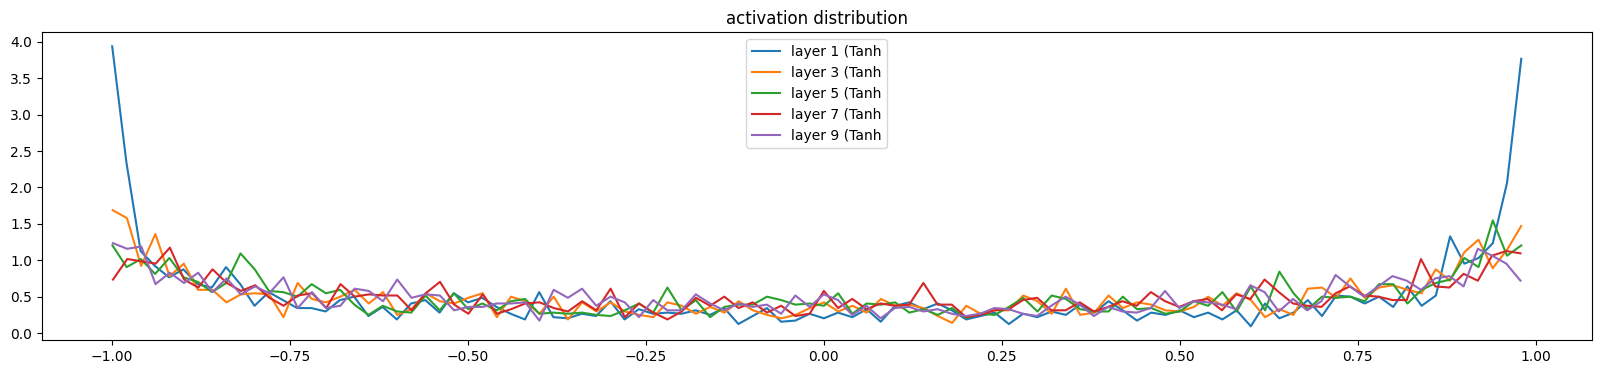

In [14]:
plot_forward_tanh(layers)

### Initialisation des couches linéaires sans facteur

46497
      0/      1: 3.2988
layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


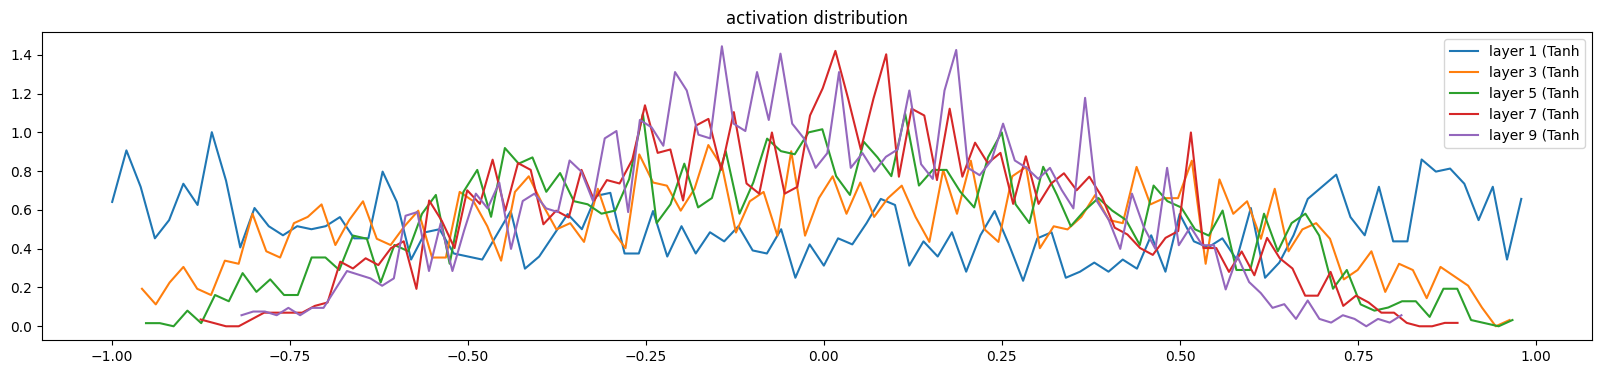

In [15]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1  # !!!
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_forward_tanh(layers)

### Initialisation avec un facteur trop grand

46497
      0/      1: 3.2801
layer 1 (      Tanh): mean -0.03, std 0.85, saturated: 47.66%
layer 3 (      Tanh): mean +0.00, std 0.84, saturated: 40.47%
layer 5 (      Tanh): mean -0.01, std 0.84, saturated: 42.38%
layer 7 (      Tanh): mean -0.01, std 0.84, saturated: 42.00%
layer 9 (      Tanh): mean -0.03, std 0.84, saturated: 42.41%


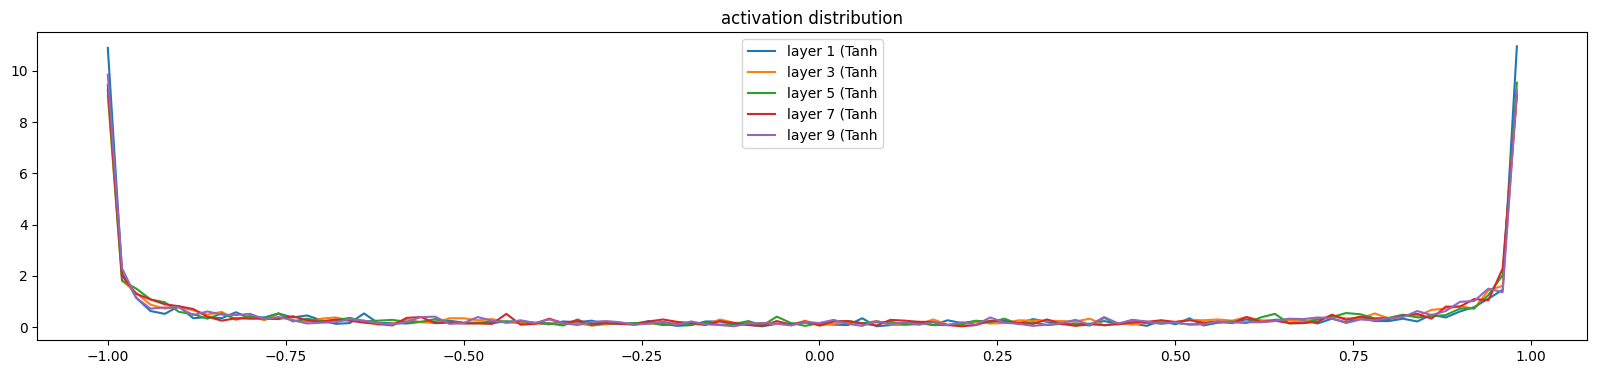

In [16]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3.0  # !!!
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_forward_tanh(layers)

$5\over 3$ semble donc être un bon facteur empirique.

## Passe arrière

In [17]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [18]:
def plot_backward_tanh(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
      if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('gradient distribution')

      0/      1: 3.2962
layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


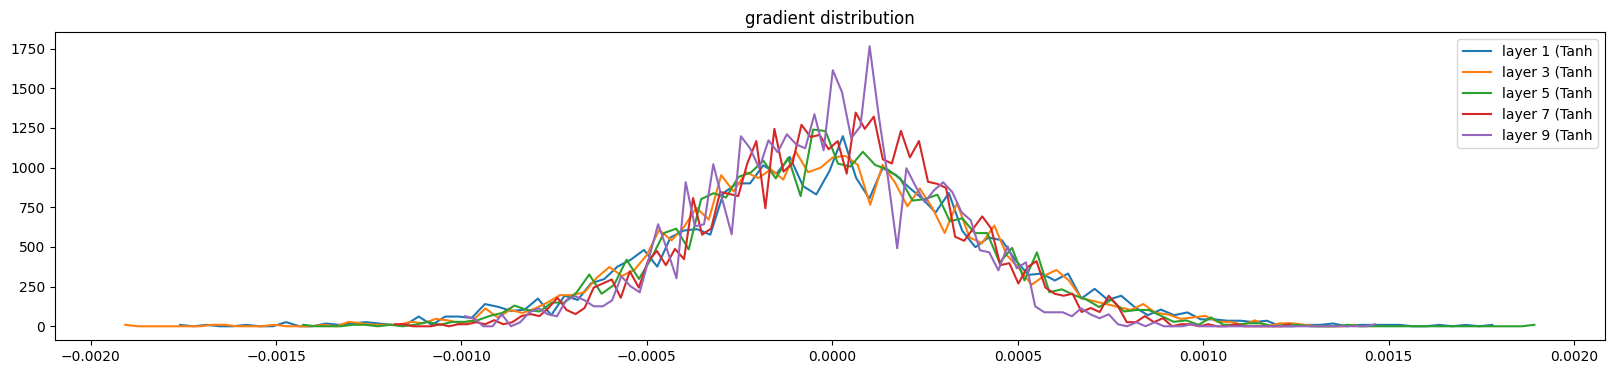

In [19]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_backward_tanh(layers)

In [20]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


      0/      1: 3.2960
layer 1 (      Tanh): mean +0.000000, std 1.892402e-05
layer 3 (      Tanh): mean -0.000001, std 3.943546e-05
layer 5 (      Tanh): mean +0.000004, std 8.035369e-05
layer 7 (      Tanh): mean +0.000009, std 1.561152e-04
layer 9 (      Tanh): mean -0.000014, std 3.053498e-04


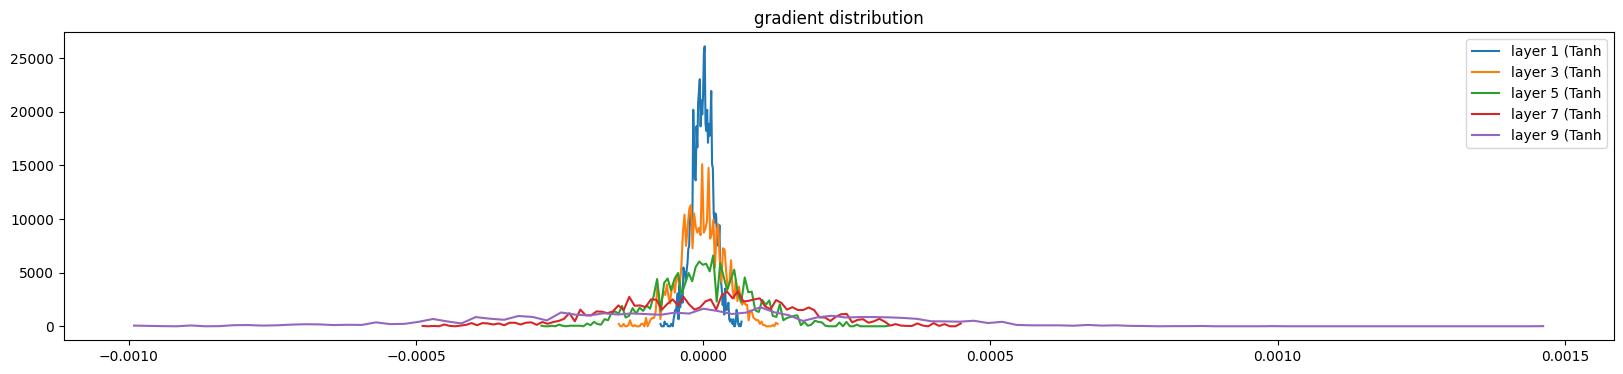

In [21]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_backward_tanh(layers)

In [22]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


      0/      1: 3.2801
layer 1 (      Tanh): mean -0.000001, std 9.977492e-04
layer 3 (      Tanh): mean +0.000010, std 7.421207e-04
layer 5 (      Tanh): mean +0.000003, std 5.569780e-04
layer 7 (      Tanh): mean +0.000017, std 3.952166e-04
layer 9 (      Tanh): mean -0.000014, std 3.051525e-04


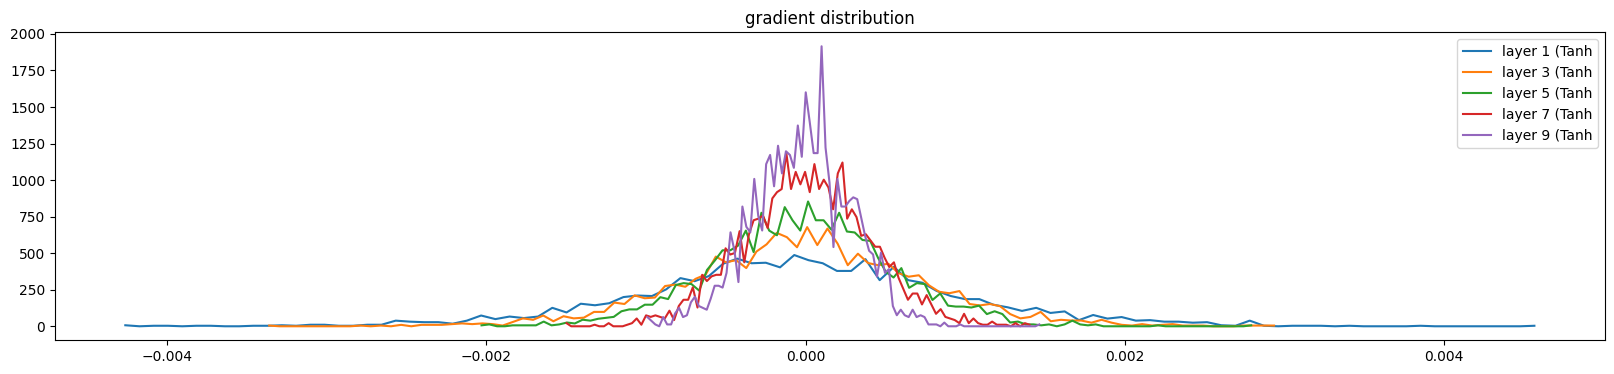

In [23]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)
plot_backward_tanh(layers)

## Sans tanh

In [24]:
g = torch.Generator().manual_seed(2147483648) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), #Tanh(),
  Linear(             n_hidden, n_hidden), #Tanh(),
  Linear(             n_hidden, n_hidden), #Tanh(),
  Linear(             n_hidden, n_hidden), #Tanh(),
  Linear(             n_hidden, n_hidden), #Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3.0
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [25]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/      1: 4.0358


In [26]:
def plot_forward_linear(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, Linear):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')

def plot_backward_linear(layers):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
      if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('gradient distribution')

layer 0 (    Linear): mean -0.09, std 1.55, saturated: 53.31%
layer 1 (    Linear): mean -0.08, std 2.55, saturated: 70.00%
layer 2 (    Linear): mean +0.11, std 4.36, saturated: 83.56%
layer 3 (    Linear): mean +0.93, std 7.57, saturated: 89.94%
layer 4 (    Linear): mean +0.02, std 13.02, saturated: 93.66%


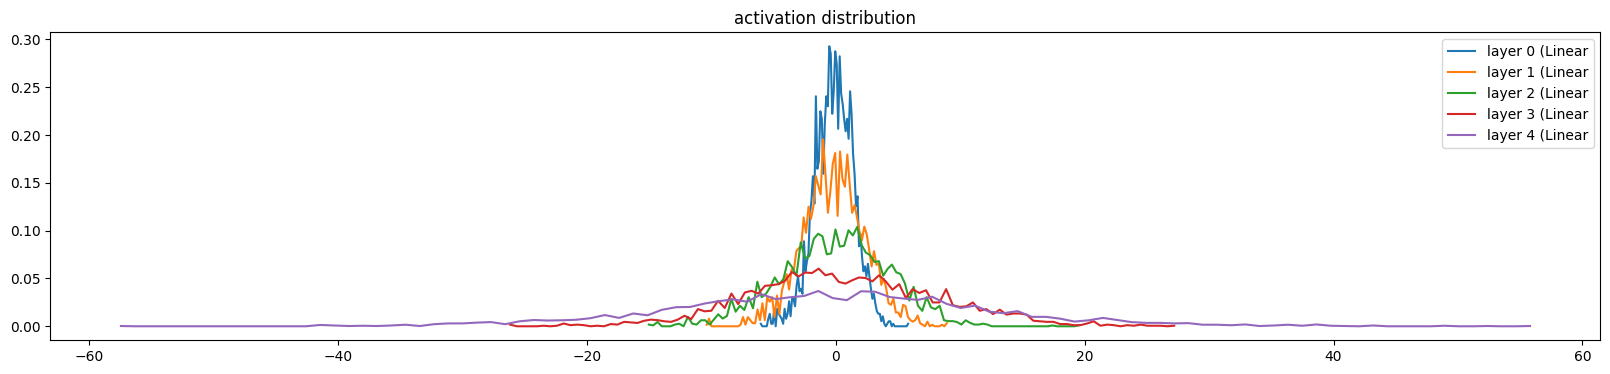

In [27]:
plot_forward_linear(layers)

layer 0 (    Linear): mean +0.000071, std 2.593055e-03
layer 1 (    Linear): mean -0.000084, std 1.475493e-03
layer 2 (    Linear): mean +0.000044, std 9.015454e-04
layer 3 (    Linear): mean +0.000032, std 5.594442e-04
layer 4 (    Linear): mean +0.000012, std 3.289250e-04


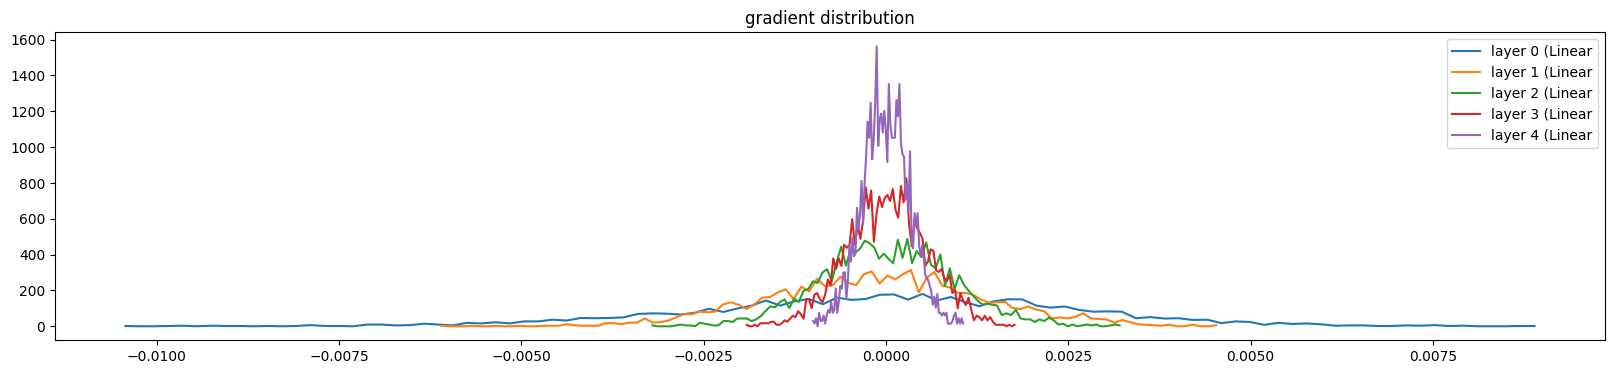

In [28]:
plot_backward_linear(layers)

On peut donc voir que sans la normalisation de type "Batch Normalisation", régler les interactions entre les différentes couches est un exercice difficile (A. Karpathy: ["_balancing a pencil on a finger_"](https://www.google.com/search?q=balancing+a+pencil+on+a+finger&dpr=2). 

In [29]:
## Interlude

In [30]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [31]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/      1: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%
layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


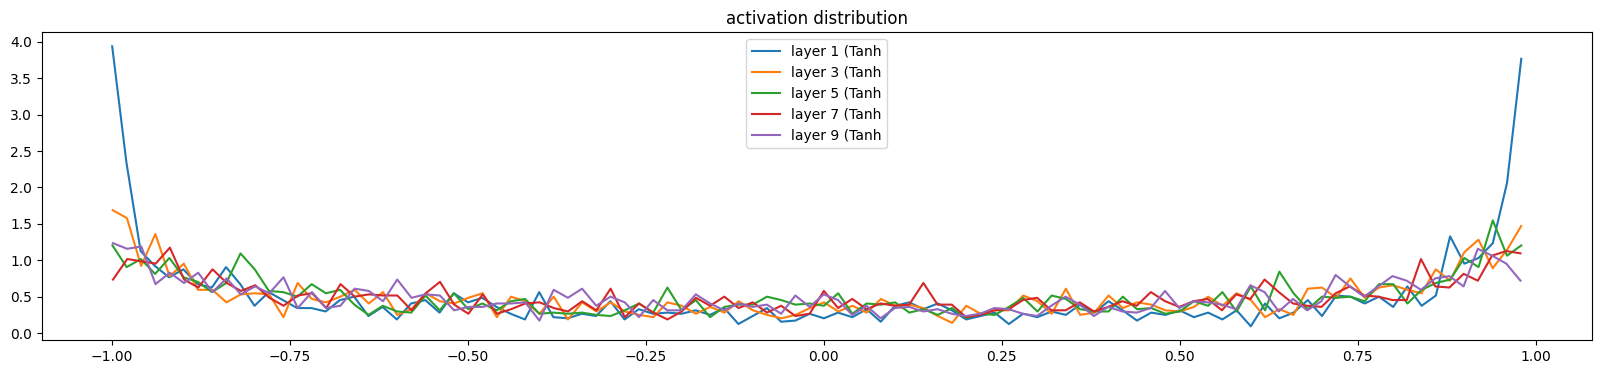

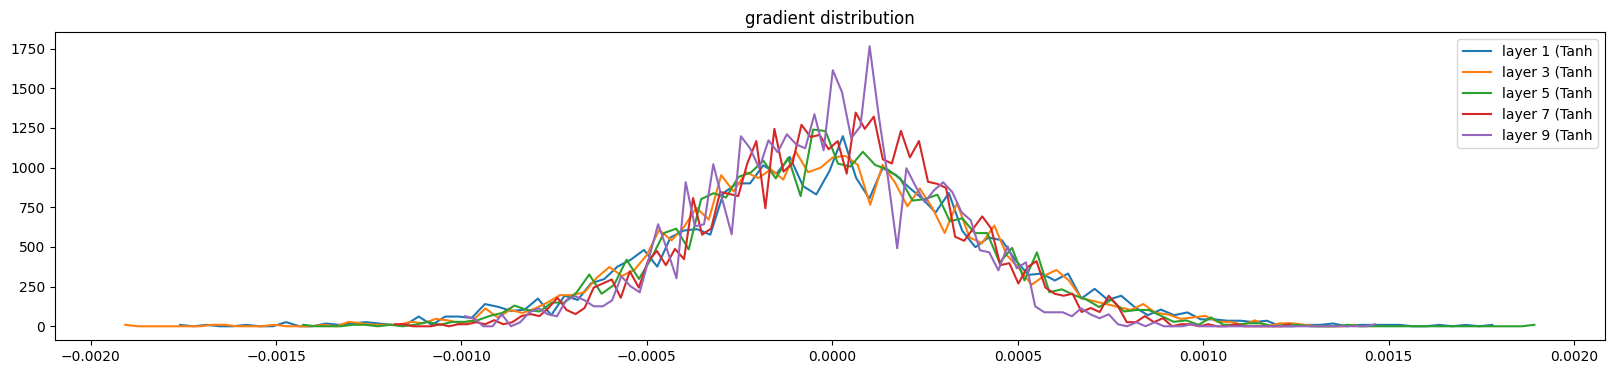

In [32]:
plot_forward_tanh(layers)
plot_backward_tanh(layers)

### grad/data ratio

In [33]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [34]:
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/      1: 3.2962


In [35]:
def plot_weight_parameters_gradients(parameters):
    # visualize histograms
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i,p in enumerate(parameters):
        t = p.grad
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution');

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388577e-04 | grad:data ratio 4.415212e-03
weight  (100, 27) | mean +0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


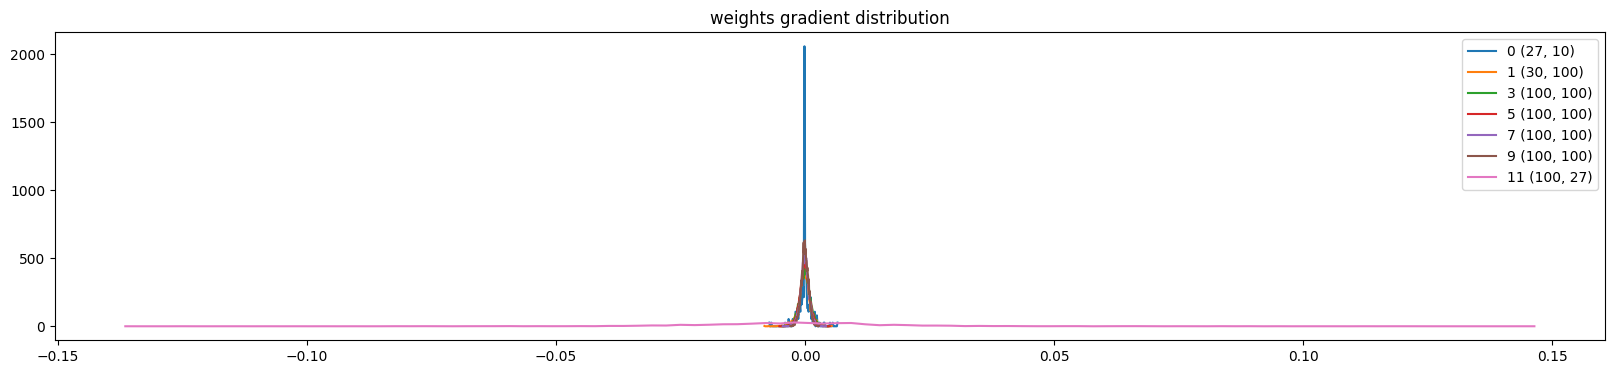

In [36]:
plot_weight_parameters_gradients(parameters)

In [37]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [38]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 3.2962


weight   (27, 10) | mean +0.001160 | std 1.115500e-02 | grad:data ratio 1.115438e-02
weight  (30, 100) | mean -0.000190 | std 8.714270e-03 | grad:data ratio 2.786435e-02
weight (100, 100) | mean -0.000086 | std 7.232301e-03 | grad:data ratio 4.302936e-02
weight (100, 100) | mean +0.000009 | std 6.865449e-03 | grad:data ratio 4.049632e-02
weight (100, 100) | mean -0.000029 | std 6.951797e-03 | grad:data ratio 4.118749e-02
weight (100, 100) | mean -0.000088 | std 6.168607e-03 | grad:data ratio 3.664632e-02
weight  (100, 27) | mean -0.000000 | std 2.263843e-02 | grad:data ratio 3.205104e-01


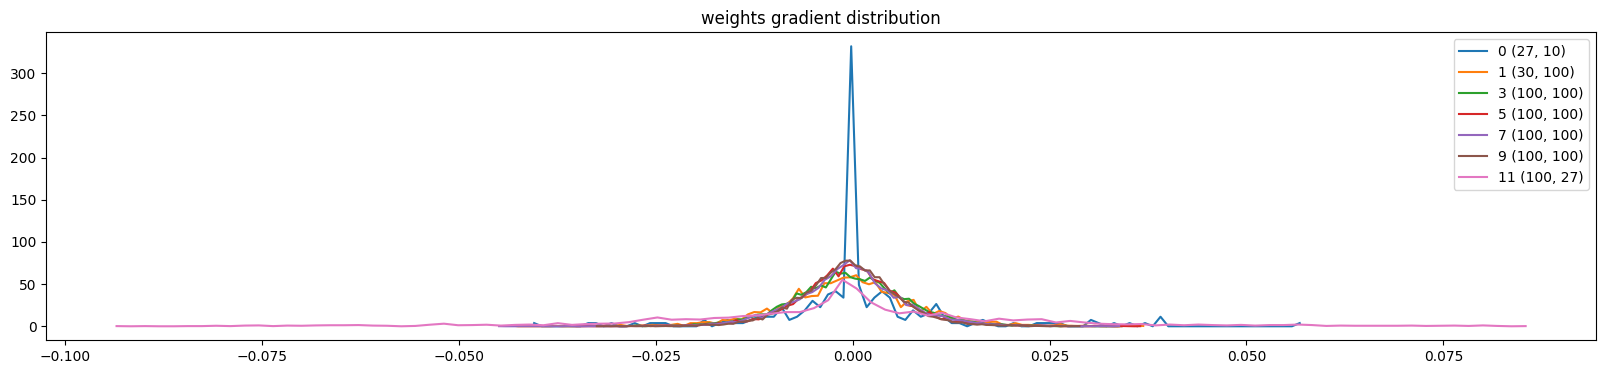

In [39]:
plot_weight_parameters_gradients(parameters)

## update data ratio

In [40]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [41]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 3.2962


In [42]:
def plot_update_weights_ratio(parameters):
    plt.figure(figsize=(20, 4))
    legends = []
    for i,p in enumerate(parameters):
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends);

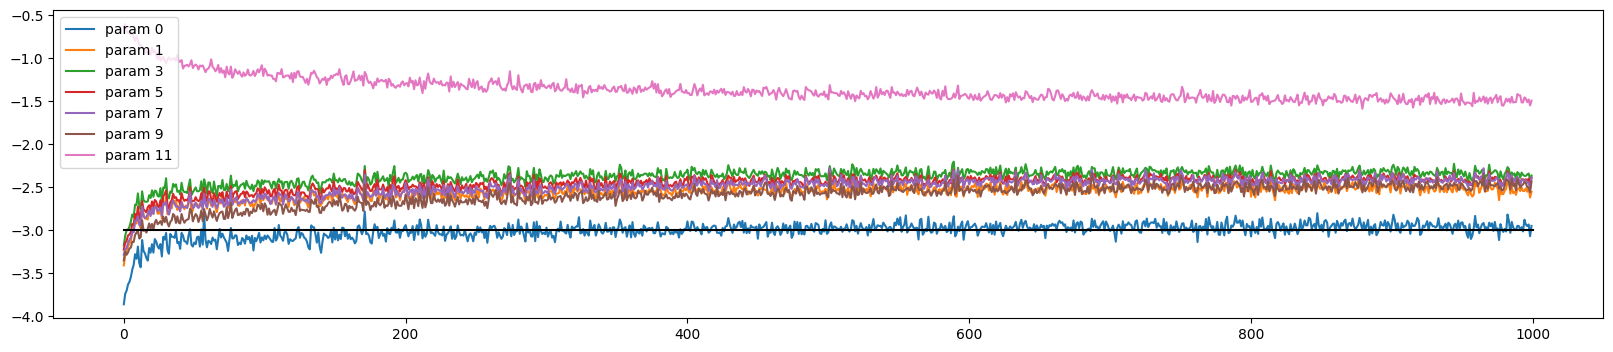

In [43]:
plot_update_weights_ratio(parameters)

In [44]:
def train(X, Y, C, layers, max_steps, batch_size, g):
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.001 # if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    return lossi, ud

In [45]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [46]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 3.2962


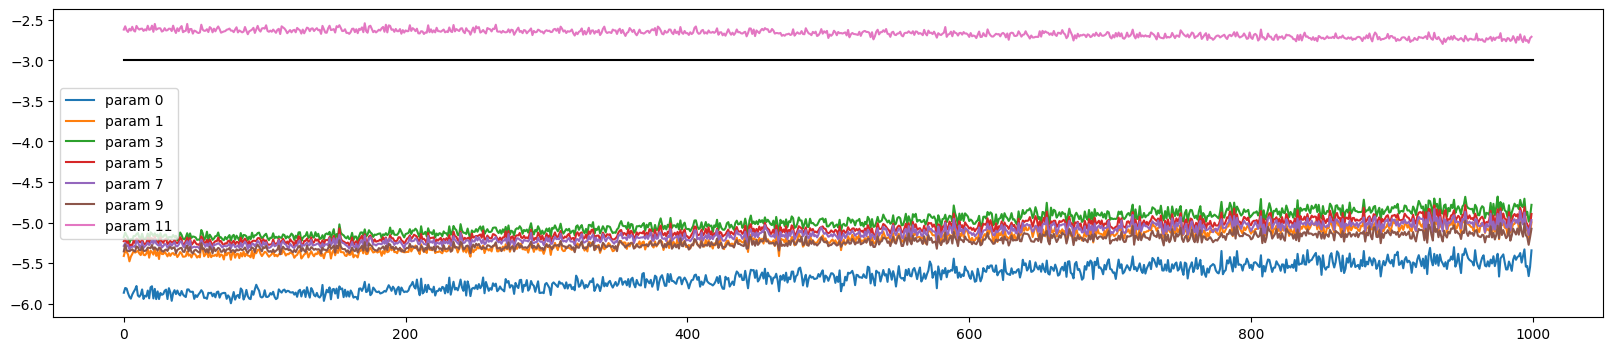

In [47]:
plot_update_weights_ratio(parameters)

## Un détail qui change tout

In [48]:
# Original training
def train(X, Y, C, layers, max_steps, batch_size, g):
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    return lossi, ud

In [49]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)  # / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [50]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [51]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 3.7560


layer 1 (      Tanh): mean +0.10, std 0.99, saturated: 97.19%
layer 3 (      Tanh): mean +0.02, std 0.98, saturated: 91.12%
layer 5 (      Tanh): mean +0.00, std 0.98, saturated: 89.59%
layer 7 (      Tanh): mean -0.00, std 0.98, saturated: 89.38%
layer 9 (      Tanh): mean -0.03, std 0.98, saturated: 90.25%
layer 1 (      Tanh): mean +0.000687, std 1.131087e-01
layer 3 (      Tanh): mean -0.000421, std 3.410301e-02
layer 5 (      Tanh): mean +0.000336, std 1.458243e-02
layer 7 (      Tanh): mean +0.000323, std 4.910041e-03
layer 9 (      Tanh): mean +0.000004, std 1.822790e-03
weight   (27, 10) | mean -0.014797 | std 3.523528e-01 | grad:data ratio 1.443013e-01
weight  (30, 100) | mean +0.000685 | std 1.683830e-01 | grad:data ratio 8.776347e-02
weight (100, 100) | mean +0.000431 | std 3.583839e-02 | grad:data ratio 2.145857e-02
weight (100, 100) | mean +0.000102 | std 1.109439e-02 | grad:data ratio 6.604380e-03
weight (100, 100) | mean +0.000033 | std 4.837320e-03 | grad:data ratio 2.8

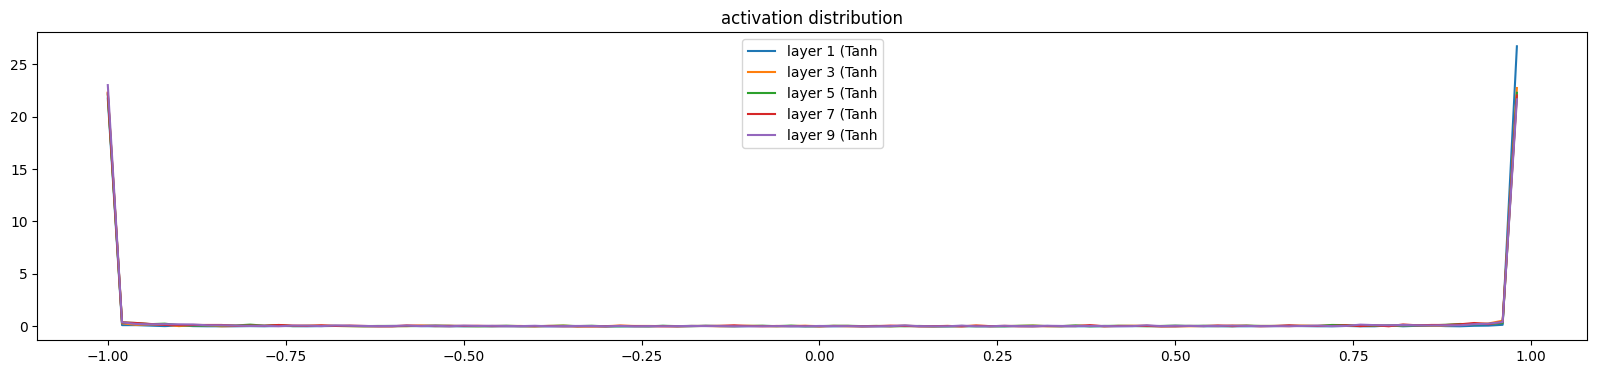

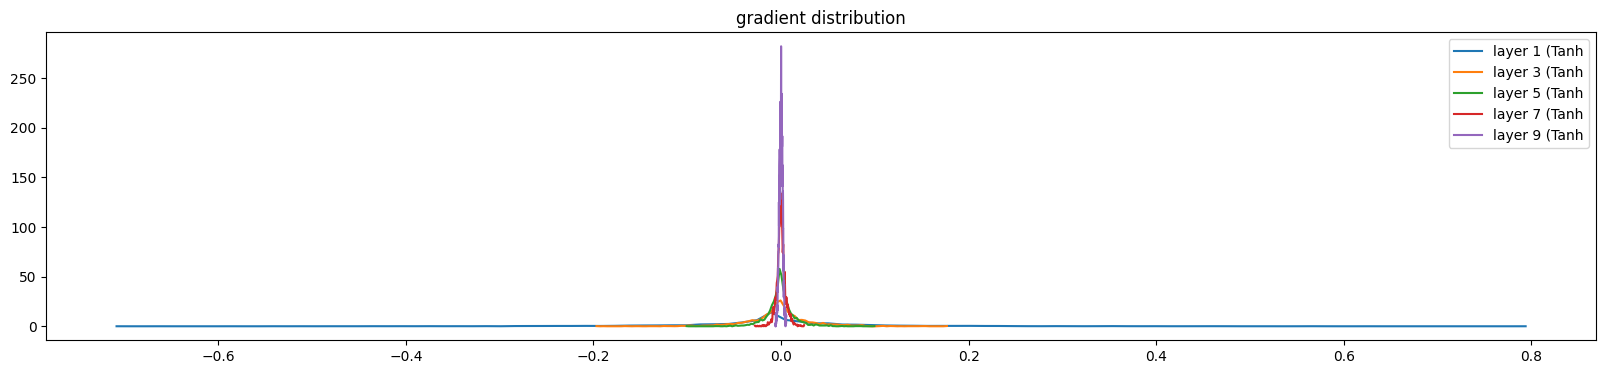

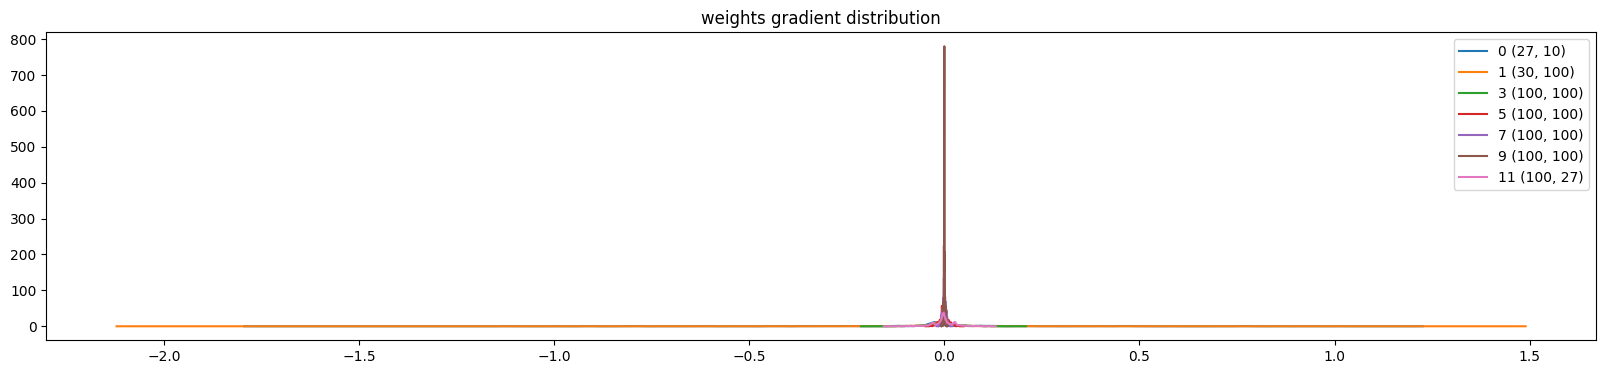

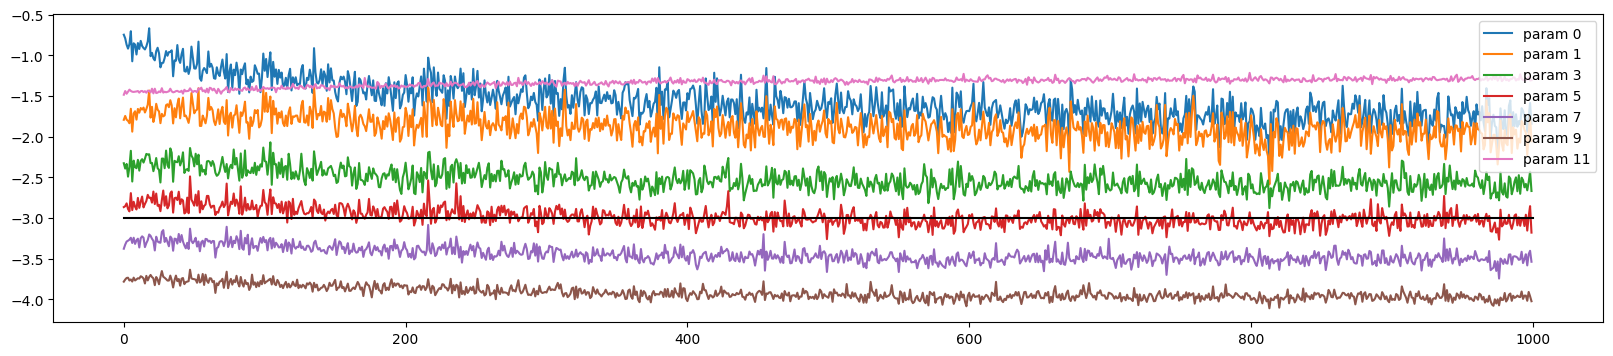

In [52]:
plot_forward_tanh(layers)
plot_backward_tanh(layers)
plot_weight_parameters_gradients(parameters)
plot_update_weights_ratio(parameters)

In [53]:
## Batch Normalization

In [54]:
### Nouvelles couches

In [55]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        #self.weight = torch.randn((fan_in, fan_out), generator=g)
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [56]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
#layers = [
#  Linear(n_embd * context_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#  Linear(             n_hidden, vocab_size), BatchNorm1d(vocab_size),
#]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            #layer.weight *= 5/3
            layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [57]:
def train(X, Y, C, layers, max_steps, batch_size, g):
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        #lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        lr = 1.0
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    return lossi, ud

In [58]:
max_steps = 1000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/   1000: 3.2870


layer 2 (      Tanh): mean +0.02, std 0.63, saturated: 4.03%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 3.69%
layer 8 (      Tanh): mean -0.03, std 0.64, saturated: 3.50%
layer 11 (      Tanh): mean -0.01, std 0.63, saturated: 2.72%
layer 14 (      Tanh): mean +0.01, std 0.64, saturated: 2.97%
layer 2 (      Tanh): mean +0.000000, std 3.763053e-03
layer 5 (      Tanh): mean +0.000000, std 3.293543e-03
layer 8 (      Tanh): mean +0.000000, std 3.161100e-03
layer 11 (      Tanh): mean -0.000000, std 3.159392e-03
layer 14 (      Tanh): mean -0.000000, std 3.233070e-03
weight   (27, 10) | mean +0.000000 | std 8.955849e-03 | grad:data ratio 8.680644e-03
weight  (30, 100) | mean -0.000111 | std 2.353011e-03 | grad:data ratio 2.289598e-03
weight (100, 100) | mean -0.000011 | std 1.196803e-03 | grad:data ratio 1.199807e-03
weight (100, 100) | mean -0.000007 | std 1.082760e-03 | grad:data ratio 1.074270e-03
weight (100, 100) | mean +0.000012 | std 1.030783e-03 | grad:data ratio 1.02

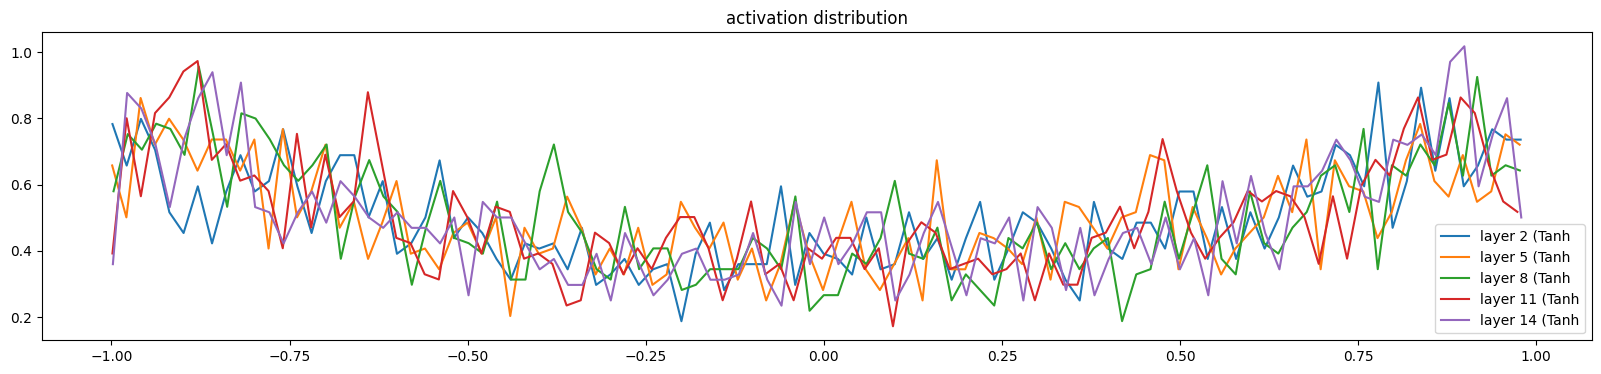

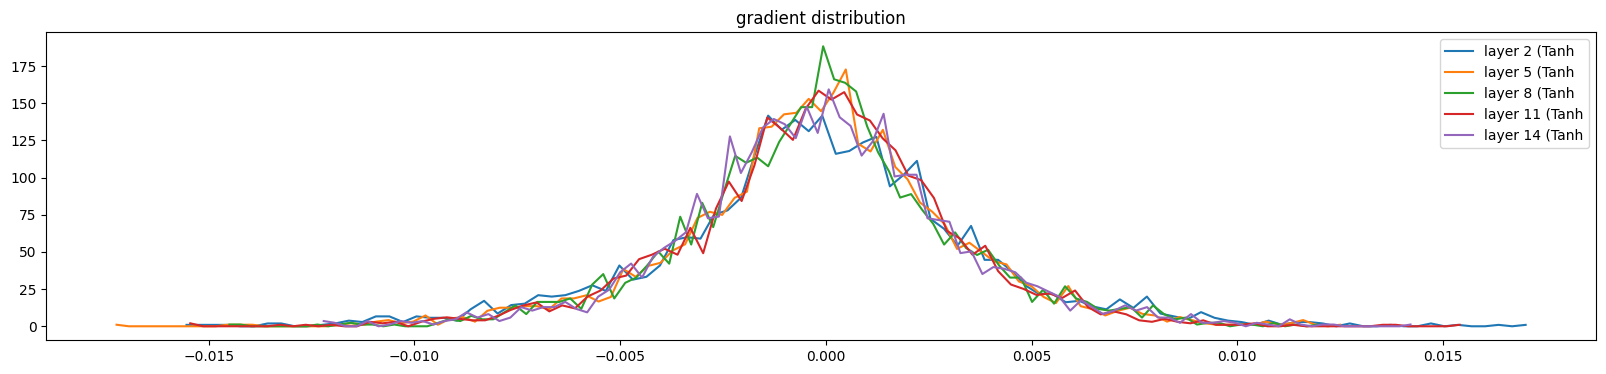

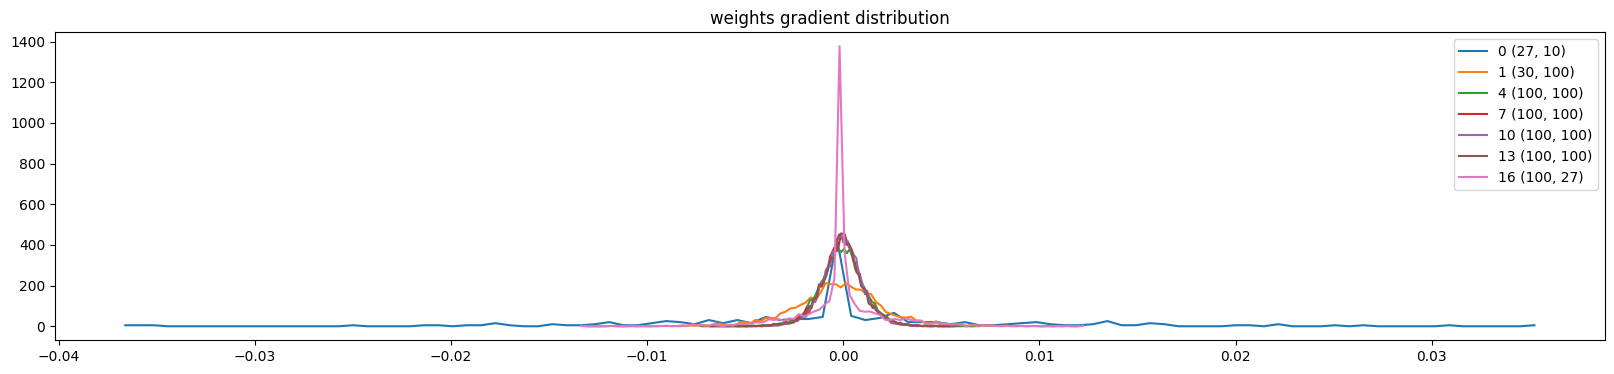

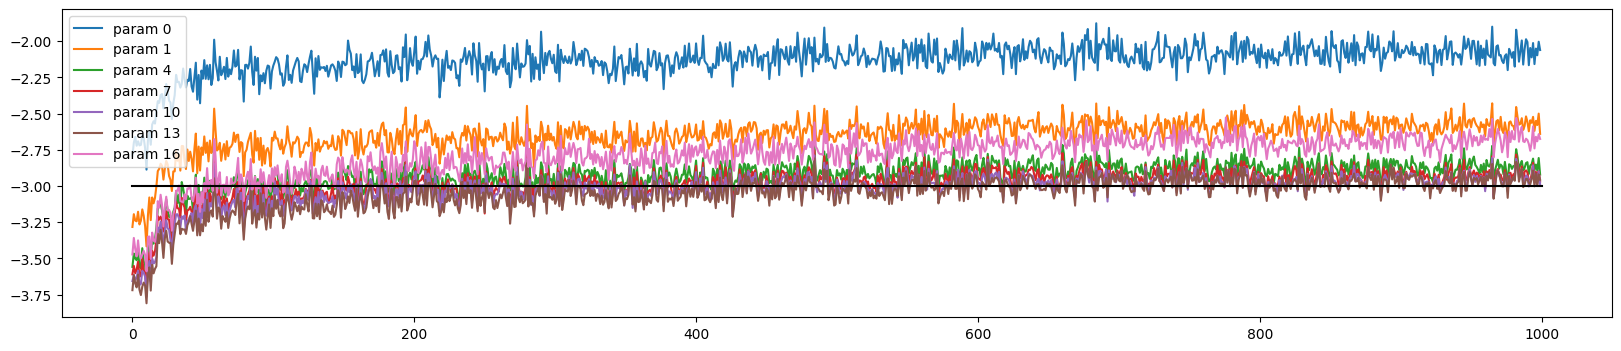

In [59]:
plot_forward_tanh(layers)
plot_backward_tanh(layers)
plot_weight_parameters_gradients(parameters)
plot_update_weights_ratio(parameters)

In [60]:
## Synthèse

In [61]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [62]:
max_steps = 200000
lossi, ud = train(Xtr, Ytr, C, layers, max_steps, batch_size, g)

      0/ 200000: 3.2870
  10000/ 200000: 2.3593
  20000/ 200000: 2.1601
  30000/ 200000: 2.1586
  40000/ 200000: 2.2735
  50000/ 200000: 2.2420
  60000/ 200000: 1.7261
  70000/ 200000: 2.1799
  80000/ 200000: 2.3887
  90000/ 200000: 2.0485
 100000/ 200000: 2.4273
 110000/ 200000: 2.2447
 120000/ 200000: 2.2675
 130000/ 200000: 1.9312
 140000/ 200000: 1.6807
 150000/ 200000: 1.9390
 160000/ 200000: 2.1248
 170000/ 200000: 1.9591
 180000/ 200000: 2.3149
 190000/ 200000: 1.9743


In [65]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for layer in layers:
  layer.training = False
for _ in range(20):
    out = []
    context = [0] * context_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        # if we sample the special '.' token, break
        if ix == 0:
            break
        else:
            out.append(ix)

    print(''.join(words.itoc[i] for i in out)) # decode and print the generated word

carmah
aar
harlin
mish
taty
skanys
esmahnen
deviah
sareei
nellara
chaiir
kaleigh
ham
ford
quinton
lilah
jadalyn
jero
dearistick
evairuvi
